Imports


In [1]:
from sage.graphs.graph_decompositions.vertex_separation import vertex_separation
from sage.graphs.graph_decompositions.vertex_separation import linear_ordering_to_path_decomposition
from sage.graphs.distances_all_pairs import diameter
from sage.graphs.distances_all_pairs import distances_all_pairs, eccentricity, floyd_warshall
from sage.misc.search import search

import matplotlib.pyplot as plt
import time

In [2]:

g = graphs.CycleGraph(10)
#pw, L = vertex_separation(g, algorithm = "BAB")
L = list(range(10))
#shuffle(L)

def length(g, L) : #Etant donne un layout L sur un graphe G, en determiner la length
    distance = distances_all_pairs(g) 
    path = linear_ordering_to_path_decomposition(g,L)
    diam= 0
    for bag in path.vertices() :
        for u in bag :
            for v in bag :
                if distance[u][v] > diam :
                    diam = distance[u][v]
    return diam

def layout_to_decomp(g,L) :
    bags = []
    for i in range(len(L))  :
        v = L[i]
        Bv = [v]
        for u in L[:i] :
            for w in g.neighbors(u) : 
                if w not in L[:i] :
                    Bv.append(u)
                    break
        bags.append(Bv)
        
    return bags

def length2(g, L) : #Etant donne un layout L sur un graphe G, determiner la length de ce dernier
    distance = distances_all_pairs(g) 
    path = layout_to_decomp(g,L)
    diam= 0
    for bag in path :
        for u in bag :
            for v in bag :
                if distance[u][v] > diam :
                    diam = distance[u][v]
    return diam



def is_path_decomposition(g, path) : 
    V = Set(g.vertices())
    X = Set([])
    #i) union is all vertices
    for bag in path :
        X = X.union(Set(bag))
    if X.cardinality() != V.cardinality() :
        print("rule 1")
        return False
    #ii) each edge appears in a bag 
    flag = False
    for u,v in g.edges(labels=False) :
        for bag in path :
            if (u in bag) and (v in bag) :
                flag = True
                break
    if not flag :
        print("rule 2")
        return False
    
    #iii) for all i<=j<=k, Xi inter Xk included in Xj
    X= map(Set,path)
    for i in range(len(X)) :
        for j in range(i,len(X)) :
            for k in range(j, len(X)) :
                if not (X[i].intersection(X[k])).issubset(X[j]) :
                    print("rule 3")
                    print(i,j,k)
                    return False
    return True
    


In [3]:


def lower_bound(g) :
    
    
    
    d = distances_all_pairs(g) 
    ecc = eccentricity(g)
    s = 0
    t = 0
    w = 0
    diam = 1
    m2 = 1
    for i in g :#improvement : check all diameters, not just one.
        for j in g :
            if d[i][j] > diam :
                    diam = d[i][j]
                    s = i
                    t= j
    #s,t achieves a diameter
    
    diameters = set([(s,t)])
    for i in g :#improvement : check all diameters, not just one.
        for j in g :
            if d[i][j] == diam :
                    diameters=diameters.union(set([(i,j)]))
                          
    LB = 1
    star = (s,t,w,-1)
    for s,t in diameters :                                      
        for i in g : 
            if min(d[i][s],d[i][t]) > m2 :
                m2 = min(d[i][s],d[i][t])
                w = i
            elif min(d[i][s],d[i][t]) == m2 and ecc[i] > ecc[w] :
                w = i

        L1 = [set() for _ in range(diam+1)]
        L2 = [set() for _ in range(diam+1)]
        L3 = [set() for _ in range(diam+1)]
        for v in g.vertices() :
            L1[d[s][v]] = L1[d[s][v]].union(set([v]))
            L2[d[t][v]] = L2[d[t][v]].union(set([v]))
            L3[d[w][v]] = L3[d[w][v]].union(set([v]))
        k = 0
        while k < m2 : 
            k+=1
            inter = L1[k].intersection(L2[k].intersection(L3[k])) 
            if  inter :
                v = list(inter)[0]
                if (d[t][s] == d[t][v] + d[v][s]) and (d[t][w] == d[t][v] + d[v][w]) and (d[w][s] == d[w][v] + d[v][s]) :  
                    if k > LB :
                        LB = k
                        star = (s,t,w,v)
                else :
                    break

            #inter1 = L1[k].intersection(L2[k])
            #inter2 = L1[k].intersection(L3[k])
            #inter3 = L3[k].intersection(L2[k])
            #if inter1 or inter2 or inter3 :
            #    break



    return LB, star

def lower_bound2(g) : 
      
    d, sps = floyd_warshall(g,paths=True, distances=True)
    ecc = eccentricity(g)
    s = 0
    t = 0
    w = 0
    diam = 1
    m2 = 1
    for i in g :
        for j in g :
            if d[i][j] > diam :
                    diam = d[i][j]
                    s = i
                    t= j
    #s,t achieves a diameter
    
    diameters = set([(s,t)])
    for i in g : #check all diameters, not just one.
        for j in g :
            if d[i][j] == diam :
                    diameters=diameters.union(set([(i,j)]))
                          
    LB = 1
    star = (0,0,0,-1)
    for s,t in diameters :
        sp_st = [s]
        while sp_st[-1] != t :
            sp_st.append(sps[t][sp_st[-1]])
        for v in sp_st[LB:-LB] :
            L = []
            for w in g.vertices() :
                if (d[s][w] == d[s][v] + d[v][w]) and (d[t][w] == d[t][v] + d[v][w]) and (LB < min(d[s][v],d[v][w],d[v][t])) :
                    LB = min(d[s][v],d[v][w],d[v][t])
                    star = (s,t,w,v)
            if d[s][v] < LB or d[v][t] < LB :
                break


    return LB






def two_approximation(g) : #2-approximation algorithm by **Dragan, Kohler, Leitert** 
    d = distances_all_pairs(g) 
    diam = diameter(g) #these two operations can be fused 
    best_bags = []
    for s in g.vertices() :
        current_diam = 0
        L = [[] for _ in g.vertices()]
        Lplus = [[] for _ in g.vertices()]
        Lplus[0]= [s]
        for v in g.vertices() :
            L[d[s][v]].append(v)
        for i in range(1,len(L)) :
            Lplus[i] = list(L[i])
            for v in L[i-1] :
                if not Set(g.neighbors(v)).intersection(Set(L[i])).is_empty():
                    Lplus[i].append(v)
            for u in Lplus[i] :
                for v in Lplus[i] :
                    if d[u][v] > current_diam :
                        current_diam = d[u][v]
        if current_diam <= diam :
            diam = current_diam
            best_bags = Lplus

    while best_bags[-1] == [] :
        best_bags.pop() #construction bourrine, nettoyage bourrin
    return best_bags, diam
                        
        
def decomp_to_layout(g,bags) :
    r = len(bags)
    
    L = list(bags[0])
    V = set(bags[0])
    for i in range(1,r) :
        Y = list(set(bags[i]).difference(V))
        while Y!=[] :
            L.append(Y.pop())
            V.add(L[-1])
    return L

In [4]:
def randomOuterPlanar(n) : 
    g = graphs.CycleGraph(n)
    g.name("Outerplanar")
    def subdivide(i,j) :
        if i == j :
            return []
        if i == j-1 :
            if randint(i,j) == j :
                return [(i,j)]
            else :
                return []
        """
        a = randint(i,j)
        b = randint(i,j)
        while b == a :
            b = randint(i,j)
        j = max(a,b)
        i = min(a,b)
        """
        
        coinflip= randint(0,1)
        if coinflip : 
            a = randint(i+1,j)
        else :
            a = randint(i,j-1)
        
        #graphs are too dense,add a coinflip to ignore edge
        coinflip= randint(0,1)
        if coinflip : 
            return [(i,j)] + subdivide(i,a) + subdivide(a,j)
        else :
            return subdivide(i,a) + subdivide(a,j)
            
    i = randint(0,n-1)
    j = randint(0, n-1)
    edges = subdivide(0, min(i,j)) + subdivide(min(i,j),max(i,j)) + subdivide(max(i,j),n-1)
    g.add_edges(edges)
    
    return g
        

def randomConnectedGNP(n) :
    def p(n) :
        return 2*log(n)/n
    g = graphs.RandomGNP(n,p(n))
    g2 = g.connected_components_subgraphs()[0]
    g2.relabel(inplace=True, perm = list(range(g2.order())))
    return g2

In [5]:
def show_LB(g) :
    sp = floyd_warshall(g,paths=True, distances=False)
    LB, Yk = lower_bound(g)
    s,t,w,x = Yk
    colors = {}
    if x != -1 :
        print(s,t,w,x)
        path_sx = [(s,sp[x][s])]
        path_tx = [(t,sp[x][t])]
        path_wx = [(w,sp[x][w])]

        while path_sx[-1][1] != x:
            path_sx.append( (path_sx[-1][1], sp[x][path_sx[-1][1]]))
        while path_tx[-1][1] != x:
            path_tx.append( (path_tx[-1][1], sp[x][path_tx[-1][1]]))
        while path_wx[-1][1] != x:
            path_wx.append( (path_wx[-1][1], sp[x][path_wx[-1][1]]))

        colors['red'] =  path_sx+path_tx+path_wx
    print(LB)
    p=  g.plot(edge_colors=colors)
    p.show()
    
def show_LB2(g) :
    sp = floyd_warshall(g,paths=True, distances=False)
    LB, Yk = lower_bound2(g)
    s,t,w,x = Yk
    colors = {}
    if x != -1 :
        print(s,t,w,x)
        path_sx = [(s,sp[x][s])]
        path_tx = [(t,sp[x][t])]
        path_wx = [(w,sp[x][w])]

        while path_sx[-1][1] != x:
            path_sx.append( (path_sx[-1][1], sp[x][path_sx[-1][1]]))
        while path_tx[-1][1] != x:
            path_tx.append( (path_tx[-1][1], sp[x][path_tx[-1][1]]))
        while path_wx[-1][1] != x:
            path_wx.append( (path_wx[-1][1], sp[x][path_wx[-1][1]]))

        colors['red'] =  path_sx+path_tx+path_wx
    print(LB)
    p=  g.plot(edge_colors=colors)
    p.show()

In [6]:
########CODE DE THEO QUI##################

def max_clique(G):
    """
    computes the size of the largest clique in G
    """
    return G.clique_number()


def longest_isometric_cycle(G):
    """
    computes the longest isometric cycle of G
    Algorithm by Daniel Lokshtanov
    """

    def unpack_set(S):
        """
        unpack a set of 2 values
        """
        S_list = S.list()
        return S_list[0], S_list[1]


    def power(G, k): #A remplacer par l'algorithme de folklore du calcul de puissances de graphe
        """          
        computes G power k
        """
        """
        G_pow_k = Graph()
        G_pow_k.add_vertices(G.vertices())
        """
        dist = G.distance_all_pairs() #on doit pouvoir faire mieux
        
        edges  = {}
        
        for u in G :
            for v in G :
                dist_u_v = dist[u].get(v, None)
                if not u == v and not dist_u_v == None and dist_u_v <= k: # if v isn't reachable from u, we say the distance is one more than the number of edges (~ +inf)
                    #G_pow_k.add_edge(u, v)
                    edges[(u,v)] = 1
                else :
                    edges[(u,v)] = 0
                
        return edges

    #### the actual algorithm starts here
    ans = 0
    if G.is_tree():
        return 0
    dist = G.distance_all_pairs()
    star = (-1,-1)
    
    for k in range(3, G.order()+1):
        Vk = set()
        for u in G :
            for v in G :
                if dist[u][v] == k // 2:
                    Vk.add((u, v)) #O(n²) => OK

        Ek = set()
        for u, v in Vk:
            for w, x in Vk:
                if dist[u][w] == 1 and dist[x][v] == 1:
                    Ek.add(((u,v), (w,x)))  #O(Vk²) => OK 

        Gk = Graph([Vk, Ek], format='vertices_and_edges')
        
        Gk_pow_k = power(Gk, k//2)
        
        """
        for u in G :
            for v in G :
                for x in G :
                    if (u, v) in Vk \
                    and ((u == x and k % 2 == 0) or (k % 2 == 1 and x in G.neighbor_iterator(u) and (v, x) in Vk)) \
                    and ((u, v), (v, x), None) in Gk_pow_k.edge_iterator():
                        ans = k
        """
        for u, v in Vk :
            for x in G :
                if not k%2 :
                    if u == x and Gk_pow_k[((u, v), (v, x))] :
                        ans = k
                else :
                    if (dist[x][u] == 1 and (v, x) in Vk) and Gk_pow_k[((u, v), (v, x))]:
                        ans = k
    return ans
#%prun longest_isometric_cycle(g)

In [7]:
print("Approximation demo")
g = randomOuterPlanar(100)
#p = g.plot()
#p.show()
%prun two_approximation(g)

Approximation demo
 

1er algo : Branch and Bound with greedy exploration

In [8]:
def gBAB(g, distances, P,  P_star, UB, LB, D, coupes, count, last_bag = None) :#Implements a step of gBAB for a given prefix
    count+=1
    if UB == LB :
        return UB, P_star, coupes, count
    
    r = len(P)
    n = g.order()
    
    
    if r == n : #The layout is complete
        if D < UB :
            return D, P, coupes +1, count
        else : 
            return UB, P_star, coupes +1, count 
    
    S = set(P)
    V = set(g)
    V_S = V.difference(S)
    
    
    if last_bag is None :
        last_bag = bag(g,P,P[-1]) 
    set_last_bag = set(last_bag)
    
    
    
    #Extension Lemma : 
    # if c is a connected component on G\S such that 
    # - N(C) is included in SUC
    # - diameter(SUC) = diameter(S)
    #Then there exists an optimal layout prefixed by P that is
    #also prefixd by P.C
    
    #Determine the list of candidates : it is faster than the extension lemma computation
    #and can be used to prune a branch
    
    L = [[] for _ in range(n)] #List of potential candidates ordered by increasing new bag diameter
    
    #Currently, if bag diameter is equal, they are then ordered by labelling. This depends on the initial ordering
    #and therefore needs to be changed.
    
    for v in V_S :
        Bv = [v]
        flag = False
        for u in S :
            flag = False
            for w in g.neighbor_iterator(u) : 
                if w in V_S :
                    Bv.append(u)
                    flag = True
                    break
            if flag :#in this case, we have added u to the bag.
                if distances[u][v] > UB : #arbitrary comparison to mitigate computational cost
                                     # in this case, the new bag will contain an edge that breaks the bound
                    break #this will leave flag set to true
                else :
                    flag = False
        if flag :
            continue #this vertex is not interesting
        d = 0
        for u in Bv : #Naive diameter calculation
            if d > UB :
                break
            for w in Bv :
                if d > UB :
                    break
                if distances[u][w] > d : 
                    d = distances[u][w]
        if d < UB :#insertion baquet
            L[d].append((d,v,Bv)) 
    L = flatten(L, ltypes = list)
    
    if not L: #this branch is worthless
        return UB, P_star, coupes, count
    #else : there might be better candidates in the form of CC
   
    for d,v,Bv in L : #Do not explore branches that cannot be improvements to the current upper bound
        
        if UB == LB :
            return UB, P_star, coupes, count

        if d < UB  :
            Pv = list(P)
            Pv.append(v)
            UB, P_star, coupes, count = gBAB(g, distances, Pv, P_star, UB, max(LB,d), max(d,D), coupes, count, last_bag = Bv)
        else : 
            continue
    return UB, P_star, coupes, count
        
        
def pathlength_gBAB(g) : #Graph g, UB upper bound on pathlength
    
    bags, UB = two_approximation(g)
    LB1 = lower_bound2(g)
    LB2 = longest_isometric_cycle(g)//2
    LB = max(LB1, LB2, UB//2)
    distances = distances_all_pairs(g) 
    P_star = decomp_to_layout(g,bags)
    P = []
    n = g.order()
    ecc = eccentricity(g)
    def ec(i) :
        return ecc[i]
    L = sorted(list(range(n)), key = ec, reverse = True) #placeholder
    print("lower bound : ", LB)
    print("upper bound : ", UB)
    print("order by eccentricity : ",  L)
    coupes = 0
    count = 0
    if UB == LB : #If we're lucky, seize it
        return UB, P_star, coupes, count, LB
    for v in L:
        K, Pv ,coupes, count = gBAB(g, distances, [v], P_star, UB, LB, 0,coupes, count, last_bag=[v])
        if K <= UB :
            UB = K
            P_star = Pv
    return K, P_star, coupes, count, LB


In [9]:

def run2(g, V = None) :
    #avoid preliminary assumptions on vertex order
    if V == None :
        V = list(g)
        shuffle(V)
    g.relabel(inplace = True, perm=V)
    
    rev = [0 for _ in V]
    for i in range(len(V)) : #permutation inverse
        rev[V[i]] = i
    
    
    sp = floyd_warshall(g,paths=True, distances=False)
    colors = {}

    p=  g.plot(edge_colors=colors, layout = 'spring')
    p.show()
    
    pl, L, c, c2, LB  = pathlength_gBAB(g)

    #s,t,w,x = Yk
    x = -1
    if x != -1 :
        path_sx = [(s,sp[x][s])]
        path_tx = [(t,sp[x][t])]
        path_wx = [(w,sp[x][w])]

        while path_sx[-1][1] != x:
            path_sx.append( (path_sx[-1][1], sp[x][path_sx[-1][1]]))
        while path_tx[-1][1] != x:
            path_tx.append( (path_tx[-1][1], sp[x][path_tx[-1][1]]))
        while path_wx[-1][1] != x:
            path_wx.append( (path_wx[-1][1], sp[x][path_wx[-1][1]]))
        
        colors['red'] =  path_sx+path_tx+path_wx

    
    app = two_approximation(g)[1]
    print("permutation : ", V)
    print("number of layouts explored : ", c)
    print("Magnitude of total number of layouts : 10^" + str(round(log(factorial(len(g.vertices())),10))))
    print('pathlength : ', pl)
    #print("two approximation of PL : ", app)
    #print("lower bound of PL : ", LB)
    print("diameter : ", g.diameter())
    print('layout : ', L)
    print("calls to BAB : ", c2)
    print('length verifications')
    print(length2(g, L))
    print(length(g, L[::-1]))
    
    g.relabel(inplace = True, perm=rev)


**Algo 2 : use an extension property on a prefix **

**1.** Connected Components calculation

In [10]:
def cc(g, V_S, D, seen, u) :
    for v in g.neighbor_iterator(u) :
        if v in V_S :
            D.union(u,v)
            if not seen[v] :
                seen[v] = True
                cc(g, V_S, D,seen,v)
    
def connectedComponentsUF(g, S) : #find connected components of G\S with UnionFind data structure
    V_S = [v for v in g if v not in S]
    D = DisjointSet(V_S)
    seen = [False for _ in g]
    for u in V_S :
        if not seen[u] :
            cc(g, set(V_S), D, seen, u)
    
    return D
    
def connectedComponentsNative(g, S) : #for run time comparison
    V_S = [v for v in g.vertices() if v not in S]    
    g_S = g.subgraph(vertices = V_S)
    C = g_S.connected_components() #Ordered by decreasing size
    return C

def bag(g,P,v) : #Bag induced by v in prefix P over graph g
    V_S = set(g.vertex_iterator()).difference(set(P))
    Bv = [v]
    flag = False
    for u in P :
        flag = False
        for w in g.neighbor_iterator(u) : 
            if w in V_S :
                Bv.append(u)
                flag = True
                break    
    return Bv

**2**.
Greedy exploration branch and bound with prefix extension lemma, upper and lower bound usage and minor optimization.

In [32]:
def gBAB2(g, 
          distances, 
          P,  
          P_star, 
          UB, 
          LB, 
          D, 
          coupes, 
          count, 
          jumps,
          prefix_storage,
          last_bag = None, 
          max_prefix_length=20, 
          max_prefix_number=10**6) :
    
    #Implements a step of gBAB for a given prefix
    
    count+=1
    if UB == LB :
        return UB, P_star, coupes, count, jumps
    
    r = len(P)
    n = g.order()
    
    
    if r == n : #The layout is complete
        if D < UB :
            return D, P, coupes +1, count, jumps
        else : 
            return UB, P_star, coupes +1, count, jumps
    
    S = set(P)
    V = set(g)
    V_S = V.difference(S)
    
    
    if last_bag is None :
        last_bag = bag(g,P,P[-1]) 
    set_last_bag = set(last_bag)
    
    
    #make sure this prefix is worth considering
    frozen_prefix= frozenset()
    
    if r <= max_prefix_length:
        frozen_prefix = frozenset(P[i] for i in range(r))
        if frozen_prefix in prefix_storage:
            return UB, P_star, coupes, count, jumps
    

    
    #Determine the list of candidates : it is faster than the extension lemma computation
    #and can be used to prune a branch
    
    L = [[] for _ in range(n)] #List of potential candidates ordered by increasing new bag diameter
    
    #Currently, if bag diameter is equal, they are then ordered by labelling. This depends on the initial ordering
    #and therefore needs to be changed.
    
    F = [] #border of S : any new bag is exactly F \cup {v}
    diam_F = 0
    for u in S :
        flag = False
        for w in g.neighbor_iterator(u) : 
            if w in V_S :
                #we could compute diameter here
                F.append(u)
                flag = True
                break 
    for u in F :#naive diam calculation
        for v in F :
            if distances[u][v] > diam_F :
                diam_F = distances[u][v]
    if diam_F > UB : #The new bags cannot be satisfaying : this prefix is a dead end
        return UB, P_star, coupes, count, jumps
    
    for v in V_S :
        d=0
        #diam(bag_v) = max(diam F, max(dist v, s\in F))
        for u in F :
            if d > UB :
                break
            if distances[u][v] > d : 
                d = distances[u][v]
        if d < UB :#insertion baquet
            L[d].append((d,v,F+[v])) 
    L = flatten(L, ltypes = list)
    
    if not L: #this branch has no interesting leaves
        return UB, P_star, coupes, count, jumps
    #else : there might be better candidates in the form of CC
    
    
    
    
    
    #Extension Lemma 1: 
    
    # if c is a set on G\S such that 
    # - N(c) is included in S \cup c ( iff c is a connected component of G\S)
    # - diameter(SUC) = diameter(S)
    #Then there exists an optimal layout prefixed by P that is
    #also prefixd by P.C
    
    
    C = sorted(connectedComponentsUF(g,S), key = len, reverse = True) #How useful is sorting ?
    
    for c in C :
        
        ens = set_last_bag.union(c)
        #ens = S.union(c)
        d=0
        for u in ens : #Naive diameter calculation
            if d>D :
                break
            for w in ens :
                if d>D :
                    break
                if w!= u : 
                    if distances[u][w] > d : 
                        d = distances[u][w]
        if d <= D :
            
            return gBAB2(g, distances, P+list(c), P_star, UB, LB, D, coupes, count, jumps+1, prefix_storage, max_prefix_length=max_prefix_length, max_prefix_number=max_prefix_number)

    for d,v,Bv in L : #Do not explore branches that cannot be improvements to the current upper bound
        
        if UB == LB :
            return UB, P_star, coupes, count, jumps

        if d < UB  :
            Pv = list(P)
            Pv.append(v)
            UB, P_star, coupes, count, jumps= gBAB2(g, distances, Pv, P_star, UB, max(LB,d), max(d,D), coupes, count, jumps, prefix_storage,last_bag = Bv, max_prefix_length=max_prefix_length, max_prefix_number=max_prefix_number)
        else : 
            continue
            
        #prefix storage update :
        if d < UB and r <= max_prefix_length and len(prefix_storage) < max_prefix_number : #after having explored the branch
            prefix_storage.add(frozen_prefix)
            
    return UB, P_star, coupes, count, jumps
        
        
def pathlength_gBAB2(g,  max_prefix_length=50,
                          max_prefix_number=10**7) : #Graph g, UB upper bound on pathlength
    
    bags, UB = two_approximation(g)
    LB1 = lower_bound2(g)
    LB2 = longest_isometric_cycle(g)//2
    
    

    
    LB = max(LB1, LB2, UB//2)
    distances = distances_all_pairs(g) 
    P_star = decomp_to_layout(g,bags)
    P = []
    n = g.order()
    ecc = eccentricity(g)
    def ec(i) :
        return ecc[i]
    L = sorted(list(range(n)), key = ec, reverse = True) #placeholder
    #print("lower bound : ", LB)
    #print("upper bound : ", UB)
    #print("order by eccentricity : ",  L)
    coupes = 0
    count = 0
    jumps = 0
    prefix_storage = set()
    
    
    
    if UB == LB : 
        return UB, P_star, coupes, count, LB
    for v in L:
        K, Pv ,coupes, count, jumps = gBAB2(g, distances, [v], P_star, UB, LB, 0,coupes, count, jumps, prefix_storage, last_bag=[v], max_prefix_length=max_prefix_length, max_prefix_number=max_prefix_number)
        if K <= UB :
            UB = K
            P_star = Pv
            
    #print("number of stored prefixes : ", len(prefix_storage))
    print(jumps, " jumps")
    return K, P_star, coupes, count, LB


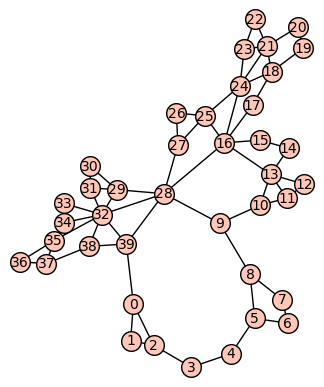

1973  jumps
permutation :  None
number of layouts explored :  2
Magnitude of total number of layouts : 10^48
pathlength :  4
diameter :  8
layout :  [3, 4, 5, 6, 8, 7, 39, 0, 2, 28, 32, 9, 38, 1, 29, 33, 34, 35, 36, 37, 30, 31, 10, 13, 11, 12, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 14, 15]
calls to BAB :  15943
length verifications
4
4


In [34]:
g= randomOuterPlanar(40)



def p(n) :
    return 2*log(n)/n
#g = graphs.RandomGNP(20,p(20))

def run(g, V = None) :
    #avoid any assumptions on vertex order
    #if V == None :
    #    V = list(g)
    #    shuffle(V)
    #g.relabel(inplace = True, perm=V)
    
    #rev = [0 for _ in V]
    #for i in range(len(V)) : #permutation inverse
    #    rev[V[i]] = i
    
    

    p=  g.plot( layout = 'spring')
    p.show()
    
    pl, L, c, c2, LB  = pathlength_gBAB2(g)

    

    
    app = two_approximation(g)[1]
    print("permutation : ", V)
    print("number of layouts explored : ", c)
    print("Magnitude of total number of layouts : 10^" + str(round(log(factorial(len(g.vertices())),10))))
    print('pathlength : ', pl)
    #print("two approximation of PL : ", app)
    #print("lower bound of PL : ", LB)
    print("diameter : ", g.diameter())
    print('layout : ', L)
    print("calls to BAB : ", c2)
    print('length verifications')
    print(length2(g, L))
    print(length(g, L[::-1]))
    
    #g.relabel(inplace = True, perm=rev)
    
    
    
    
run(g)
#while app - pl <=1 :
#    g = randomOuterPlanar(14)
#    pl, L, app = run(g)
#    print(app -pl)
#g_star_2 = g


In [13]:
"""test_graphs = [ randomOuterPlanar(i) for i in range(5, 100)]
times = [timeit("longest_isometric_cycle(test_graphs["+ str(i) +"])", number=1, seconds = False) for i in range(100)]
X = list(range(5,100))
Y = [x**4 for x in X]
plt.plot(list(range(5,100)),times)
"""

'test_graphs = [ randomOuterPlanar(i) for i in range(5, 100)]\ntimes = [timeit("longest_isometric_cycle(test_graphs["+ str(i) +"])", number=Integer(1), seconds = False) for i in range(Integer(100))]\nX = list(range(Integer(5),Integer(100)))\nY = [x**Integer(4) for x in X]\nplt.plot(list(range(Integer(5),Integer(100))),times)\n'

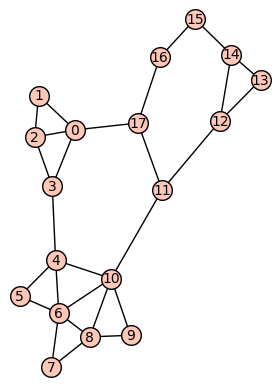

permutation :  [5, 0, 7, 8, 16, 1, 11, 13, 10, 3, 9, 15, 17, 6, 2, 4, 12, 14]
number of layouts explored :  1
Magnitude of total number of layouts : 10^16
pathlength :  3
diameter :  6
layout :  [5, 4, 6, 10, 3, 7, 8, 9, 17, 0, 2, 11, 1, 12, 13, 14, 15, 16]
calls to BAB :  53
length verifications
3
3
 

In [14]:
edges = [(0, 1),
 (0, 2),
 (0, 3),
 (0, 17),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (4, 6),
 (4, 10),
 (5, 6),
 (6, 7),
 (6, 8),
 (6, 10),
 (7, 8),
 (8, 9),
 (8, 10),
 (9, 10),
 (10, 11),
 (11, 12),
 (11, 17),
 (12, 13),
 (12, 14),
 (13, 14),
 (14, 15),
 (15, 16),
 (16, 17)]
V_rapide = [14, 8, 12, 6, 7, 17, 13, 0, 1, 16, 9, 11, 5, 2, 15, 10, 4, 3] #Few calls to BAB
V_lent = [5, 0, 7, 8, 16, 1, 11, 13, 10, 3, 9, 15, 17, 6, 2, 4, 12, 14] #Many calls to BAB
V_lent2 = [12, 11, 14, 1, 16, 8, 10, 0, 17, 9, 5, 3, 13, 15, 4, 7, 2, 6] #Explores multiple layouts
#if we sort the CC, V_lent2 is slower (more calls to bab) than if we dont sort the CC
g_star = Graph()
g_star.add_edges(edges)
%prun run(g_star,V=V_lent)

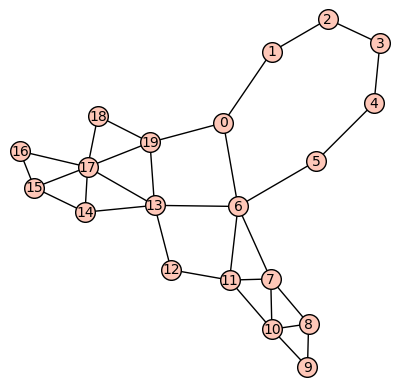

permutation :  [2, 19, 4, 15, 14, 7, 17, 18, 12, 0, 3, 13, 10, 8, 1, 11, 5, 9, 16, 6]
number of layouts explored :  2
Magnitude of total number of layouts : 10^18
pathlength :  3
diameter :  6
layout :  [2, 1, 0, 3, 5, 4, 6, 13, 19, 14, 15, 16, 18, 17, 7, 11, 12, 8, 10, 9]
calls to BAB :  416
length verifications
3
3
 

In [15]:
G2= Graph()
G2.add_edges([(0, 1),
 (0, 6),
 (0, 19),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (6, 11),
 (6, 13),
 (7, 8),
 (7, 10),
 (7, 11),
 (8, 9),
 (8, 10),
 (9, 10),
 (10, 11),
 (11, 12),
 (12, 13),
 (13, 14),
 (13, 17),
 (13, 19),
 (14, 15),
 (14, 17),
 (15, 16),
 (15, 17),
 (16, 17),
 (17, 18),
 (17, 19),
 (18, 19)])
V2 = [2, 19, 4, 15, 14, 7, 17, 18, 12, 0, 3, 13, 10, 8, 1, 11, 5, 9, 16, 6]
%prun run(G2, V2)

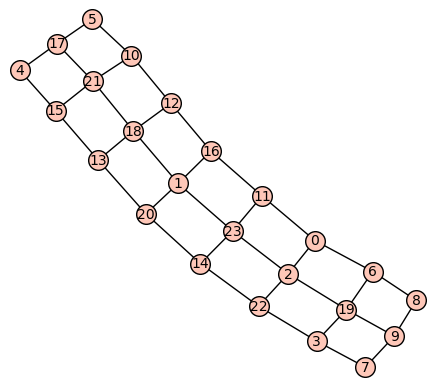

permutation :  None
number of layouts explored :  0
Magnitude of total number of layouts : 10^24
pathlength :  3
diameter :  9
layout :  [17, 21, 4, 5, 15, 18, 10, 13, 12, 1, 23, 20, 16, 14, 11, 2, 22, 19, 0, 6, 3, 9, 7, 8]
calls to BAB :  910
length verifications
3
3


In [16]:
G = graphs.Grid2dGraph(8,3)
G.relabel(inplace=True)
V = list(G)
shuffle(V)
G.relabel(inplace = True, perm=V)
run(G)

In [17]:
def trouveur() :
    while int(input()) :
        g = randomOuterPlanar(30) 
        e = g.edges() 
        g2 = Graph()
        g2.add_edges(e)

        """
        p=  g.plot(layout = 'spring')
        p.show()"""
        
        show_LB2(g2)
        
    return g2


1


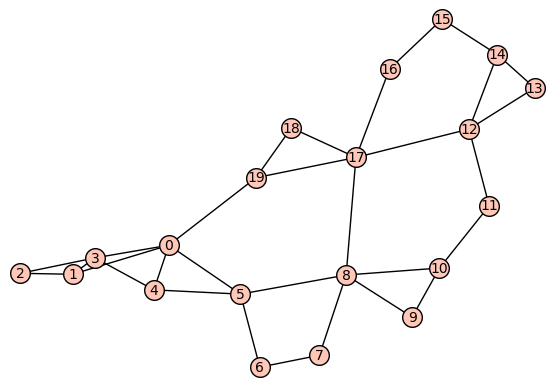

In [18]:
edges = [(0, 1),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 19),
 (1, 2),
 (1, 3),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (5, 8),
 (6, 7),
 (7, 8),
 (8, 9),
 (8, 10),
 (8, 17),
 (9, 10),
 (10, 11),
 (11, 12),
 (12, 13),
 (12, 14),
 (12, 17),
 (13, 14),
 (14, 15),
 (15, 16),
 (16, 17),
 (17, 18),
 (17, 19),
 (18, 19)]


gcass = Graph()
gcass.add_edges(edges)
show_LB(gcass)

In [19]:
def gBAB3(g, 
          distances, 
          P,  
          P_star, 
          UB, 
          LB, 
          D, 
          coupes, 
          count, 
          prefix_storage,
          last_bag = None, 
          max_prefix_length=20, 
          max_prefix_number=10**6) :
    
    #Implements a step of gBAB for a given prefix - for connected path length
    
    count+=1
    if UB == LB :
        return UB, P_star, coupes, count
    
    r = len(P)
    n = g.order()
    
    
    if r == n : #The layout is complete
        if D < UB :
            return D, P, coupes +1, count
        else : 
            return UB, P_star, coupes +1, count 
    
    S = set(P)
    V = set(g)
    V_S = V.difference(S)
    
    
    if last_bag is None :
        last_bag = bag(g,P,P[-1]) 
    set_last_bag = set(last_bag)
    
    
    #make sure this prefix is worth considering
    frozen_prefix= frozenset()
    
    if r <= max_prefix_length:
        frozen_prefix = frozenset(P[i] for i in range(r))
        if frozen_prefix in prefix_storage:
            return UB, P_star, coupes, count
    

    
    #Determine the list of candidates : it is faster than the extension lemma computation
    #and can be used to prune a branch
    
    L = [[] for _ in range(n)] #List of potential candidates ordered by increasing new bag diameter
    
    #Currently, if bag diameter is equal, they are then ordered by labelling. This depends on the initial ordering
    #and therefore needs to be changed.
    allowed = set()
    for s in P :
        allowed = allowed.union(set(g.neighbors(s)))
    

    allowed = allowed.intersection(V_S)

    
    F = [] #border of S : any new bag is exactly F \cup {v}
    diam_F = 0
    for u in S :
        flag = False
        for w in g.neighbor_iterator(u) : 
            if w in V_S :
                #we could compute diameter here
                F.append(u)
                flag = True
                break 
    for u in F :#naive diam calculation
        for v in F :
            if distances[u][v] > diam_F :
                diam_F = distances[u][v]
    if diam_F > UB : #The new bags cannot be satisfaying : this prefix is a dead end
        return UB, P_star, coupes, count
    
    for v in allowed :
        d=0
        #diam(bag_v) = max(diam F, max(dist v, s\in F))
        for u in F :
            if d > UB :
                break
            if distances[u][v] > d : 
                d = distances[u][v]
        if d < UB :#insertion baquet
            L[d].append((d,v,F+[v])) 
    L = flatten(L, ltypes = list)
    
    if not L: #this branch has no interesting leaves
        return UB, P_star, coupes, count
    #else : there might be better candidates in the form of CC
    
    
    
    
    
    #Extension Lemma 1: 
    
    # if c is a set on G\S such that 
    # - N(c) is included in S \cup c ( iff c is a connected component of G\S)
    # - diameter(SUC) = diameter(S)
    #Then there exists an optimal layout prefixed by P that is
    #also prefixd by P.C
    
    
    C = sorted(connectedComponentsUF(g,S), key = len, reverse = True) #How useful is sorting ?
    
    for c in C :
        
        ens = set_last_bag.union(c)
        #ens = S.union(c)
        d=0
        for u in ens : #Naive diameter calculation
            if d>D :
                break
            for w in ens :
                if d>D :
                    break
                if w!= u : 
                    if distances[u][w] > d : 
                        d = distances[u][w]
        if d <= D :
            return gBAB3(g, distances, P+list(c), P_star, UB, LB, D, coupes, count, prefix_storage, max_prefix_length=max_prefix_length, max_prefix_number=max_prefix_number)
    

    for d,v,Bv in L : #Do not explore branches that cannot be improvements to the current upper bound

        if UB == LB :
            return UB, P_star, coupes, count

        if d < UB  :
            Pv = list(P)
            Pv.append(v)
            UB, P_star, coupes, count = gBAB3(g, distances, Pv, P_star, UB, max(LB,d), max(d,D), coupes, count, prefix_storage,last_bag = Bv, max_prefix_length=max_prefix_length, max_prefix_number=max_prefix_number)
        else : 
            continue
            
        #prefix storage update :
        if d < UB and r <= max_prefix_length and len(prefix_storage) < max_prefix_number : #after having explored the branch
            prefix_storage.add(frozen_prefix)
            
    return UB, P_star, coupes, count
        
        
def pathlength_gBAB3(g,  max_prefix_length=50,
                          max_prefix_number=10**7) : #Graph g, UB upper bound on pathlength
    
    bags, UB = two_approximation(g)
    LB1 = lower_bound2(g)
    LB2 = longest_isometric_cycle(g)//2
    
    

    
    LB = max(LB1, LB2, UB//2)
    distances = distances_all_pairs(g) 
    P_star = decomp_to_layout(g,bags)
    P = []
    n = g.order()
    ecc = eccentricity(g)
    def ec(i) :
        return ecc[i]
    L = sorted(list(range(n)), key = ec, reverse = True) #placeholder
    #print("lower bound : ", LB)
    #print("upper bound : ", UB)
    #print("order by eccentricity : ",  L)
    coupes = 0
    count = 0
    prefix_storage = set()
    
    experimental = False
    
    if UB == LB : 
        return UB, P_star, coupes, count, LB
    for v in L:
        
        #conjecture eccentricité
        if experimental :
            if  ecc[v] < ecc[L[0]] :
                break
                
            
        K, Pv ,coupes, count = gBAB3(g, distances, [v], P_star, UB, 2, 0,coupes, count, prefix_storage, last_bag=[v], max_prefix_length=max_prefix_length, max_prefix_number=max_prefix_number)
        if K <= UB :
            UB = K
            P_star = Pv
            
    #print("number of stored prefixes : ", len(prefix_storage))
    return K, P_star, coupes, count, LB








def run3(g, V = None) :
    #avoid any assumptions on vertex order
    #if V == None :
    #    V = list(g)
    #    shuffle(V)
    #g.relabel(inplace = True, perm=V)
    
    #rev = [0 for _ in V]
    #for i in range(len(V)) : #permutation inverse
    #    rev[V[i]] = i
    
    
    
    colors = {}

    p=  g.plot(edge_colors=colors, layout = 'spring')
    p.show()
    
    pl, L, c, c2, LB  = pathlength_gBAB3(g)

    
    app = two_approximation(g)[1]
    print("permutation : ", V)
    print("number of layouts explored : ", c)
    print("Magnitude of total number of layouts : 10^" + str(round(log(factorial(len(g.vertices())),10))))
    print('connected pathlength : ', pl)
    #print("two approximation of PL : ", app)
    #print("lower bound of PL : ", LB)
    print("diameter : ", g.diameter())
    print('layout : ', L)
    print("calls to BAB : ", c2)
    print('length verifications')
    print(length2(g, L))
    print(length(g, L[::-1]))
    
    #g.relabel(inplace = True, perm=rev)
    


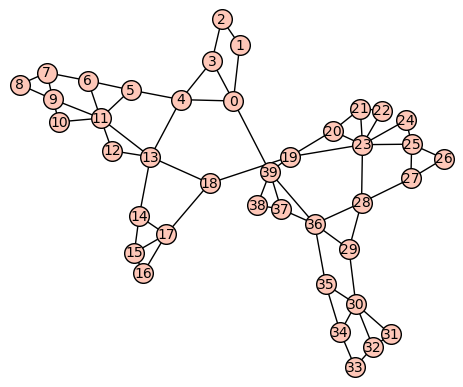

permutation :  None
number of layouts explored :  1
Magnitude of total number of layouts : 10^48
connected pathlength :  4
diameter :  10
layout :  [8, 9, 7, 10, 11, 6, 5, 13, 12, 4, 0, 3, 1, 2, 18, 19, 39, 17, 20, 23, 14, 15, 16, 28, 24, 25, 26, 27, 21, 22, 36, 29, 30, 31, 32, 33, 34, 35, 37, 38]
calls to BAB :  9914
length verifications
4
4


In [20]:
run3(g)

In [21]:
i = 0
while True : 
    i+=1
    if not i%10 : 
        print(i)
    g = randomOuterPlanar(40)
    pl, _, _, _, _  = pathlength_gBAB2(g)
    cpl, _, _, _, _  = pathlength_gBAB3(g)
    if pl != cpl :
        print(g.edges())
        break
    
    
    
    
    
    

KeyboardInterrupt: 

In [ ]:
g = randomOuterPlanar(40)



run(g)
run3(g)

In [ ]:
g_long = Graph() #300 secondes le 28/07
edges = [(0, 1),
 (0, 4),
 (0, 9),
 (0, 13),
 (0, 19),
 (1, 2),
 (1, 3),
 (2, 3),
 (3, 4),
 (4, 5),
 (4, 6),
 (4, 9),
 (5, 6),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 11),
 (10, 13),
 (11, 12),
 (11, 13),
 (12, 13),
 (13, 14),
 (13, 15),
 (13, 16),
 (14, 15),
 (15, 16),
 (16, 17),
 (16, 19),
 (17, 18),
 (17, 19),
 (18, 19)]
g_long.add_edges(edges)


In [ ]:
g_long.plot(layout='spring')

In [ ]:
run(g_long)

In [ ]:
f = open('results_gnp')

In [ ]:
f.readline()

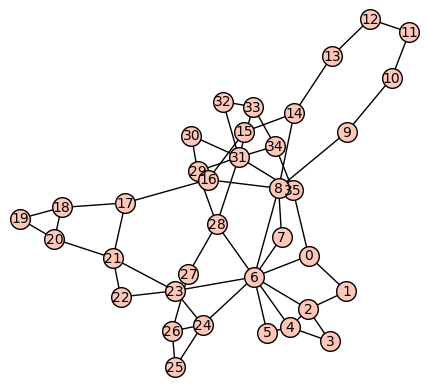

In [37]:
edges = [(0, 1), (0, 6), (0, 35), (1, 2), (2, 3), (2, 4), (2, 6), (3, 4), (4, 5), (4, 6), (5, 6), (6, 7), (6, 8), (6, 23), (6, 24), (6, 28), (7, 8), (8, 9), (8, 14), (8, 16), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (17, 21), (18, 19), (18, 20), (19, 20), (20, 21), (21, 22), (21, 23), (22, 23), (23, 24), (24, 25), (24, 26), (25, 26), (26, 27), (27, 28), (28, 29), (28, 31), (29, 30), (29, 31), (30, 31), (31, 32), (31, 33), (31, 34), (31, 35), (32, 33), (33, 34), (34, 35)]


g = Graph()
g.add_edges(edges)


g.plot()

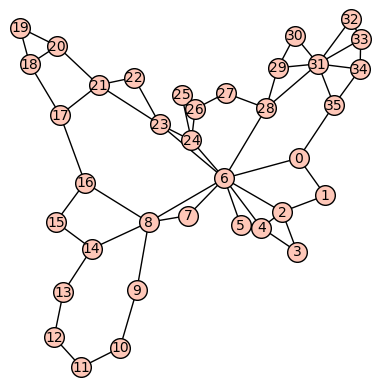

permutation :  [20, 10, 4, 30, 29, 18, 34, 26, 23, 9, 7, 15, 32, 24, 12, 2, 16, 33, 19, 25, 21, 31, 35, 8, 0, 17, 13, 28, 11, 14, 3, 27, 22, 1, 6, 5]
number of layouts explored :  1
Magnitude of total number of layouts : 10^42
connected pathlength :  4
diameter :  7
layout :  [11, 10, 9, 8, 12, 13, 14, 16, 15, 17, 18, 21, 22, 23, 6, 19, 20, 7, 24, 0, 2, 3, 4, 5, 1, 28, 35, 29, 30, 32, 33, 34, 31, 25, 26, 27]
calls to BAB :  74420
length verifications
4
4


In [26]:
run3(g, [20, 10, 4, 30, 29, 18, 34, 26, 23, 9, 7, 15, 32, 24, 12, 2, 16, 33, 19, 25, 21, 31, 35, 8, 0, 17, 13, 28, 11, 14, 3, 27, 22, 1, 6, 5])

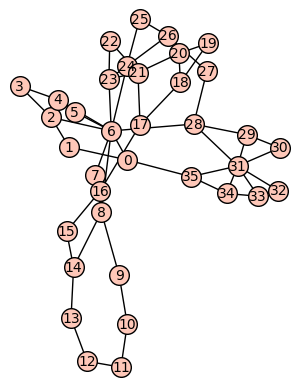

129049  jumps
permutation :  [20, 10, 4, 30, 29, 18, 34, 26, 23, 9, 7, 15, 32, 24, 12, 2, 16, 33, 19, 25, 21, 31, 35, 8, 0, 17, 13, 28, 11, 14, 3, 27, 22, 1, 6, 5]
number of layouts explored :  2
Magnitude of total number of layouts : 10^42
pathlength :  4
diameter :  7
layout :  [11, 10, 9, 8, 13, 12, 14, 6, 7, 16, 15, 21, 17, 22, 23, 20, 24, 18, 19, 0, 2, 3, 4, 5, 1, 28, 35, 29, 30, 32, 33, 34, 31, 25, 26, 27]
calls to BAB :  731119
length verifications
4
4


In [38]:
run(g, [20, 10, 4, 30, 29, 18, 34, 26, 23, 9, 7, 15, 32, 24, 12, 2, 16, 33, 19, 25, 21, 31, 35, 8, 0, 17, 13, 28, 11, 14, 3, 27, 22, 1, 6, 5])

